# Wealth transfer

This notebook presents a tutorial for beginners on how to create a simple agent-based model with the [agentpy](https://agentpy.readthedocs.io) package.
It demonstrates how to create a basic model with a custom agent type, run a simulation, record data, and visualize results.

In [14]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns

import random

## About the model

The model explores the distribution of wealth under a trading population of agents.
Each agent starts with one unit of wealth.
During each time-step, each agents with positive wealth
randomly selects a trading partner and gives them one unit of their wealth.
We will see that this random interaction will create an inequality of wealth that
follows a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).
The original version of this model been written in [MESA](https://mesa.readthedocs.io/)
and can be found [here](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html).

## Model definition

We start by defining a new type of `Agent` with the following methods:

- `setup()` is called automatically when a new agent is created and initializes a variable `wealth`.
- `wealth_transfer()` describes the agent's behavior at every time-step and will be called by the model.

In [34]:
class CleaningAgent1(ap.Agent):

     #Rodo

    def setup(self):
        self.position = [0, 0]
        self.utility = 0
        self.target_area = None

    def see(self):
        """ observa el ambiente y revisa el area con mas densidad"""
        self.environment = self.model.environment
        max_density = 0
        self.target_area = None

        # evalua la densidad que hay en espacio de 3x3
        for i in range(len(self.environment)):
            for j in range(len(self.environment[0])):
                density = 0
                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        ni, nj = i + di, j + dj
                        if 0 <= ni < len(self.environment) and 0 <= nj < len(self.environment[0]):
                            density += self.environment[ni][nj]
                if density > max_density:
                    max_density = density
                    self.target_area = [i, j]

    def move_toward_target(self):
        """ se mueve hacia el area donde hubo mas densidad en el "see"""
        if self.target_area:
            if self.target_area[0] < self.position[0]:
                self.position[0] -= 1
            elif self.target_area[0] > self.position[0]:
                self.position[0] += 1
            elif self.target_area[1] < self.position[1]:
                self.position[1] -= 1
            elif self.target_area[1] > self.position[1]:
                self.position[1] += 1

    def clean(self):
        """ limpia la celda actual si esta sucia"""
        if self.environment[self.position[0]][self.position[1]]:
            self.environment[self.position[0]][self.position[1]] = False
            self.utility += 1

    def step(self):

        self.see()
        self.clean()
        self.move_toward_target()

class CleaningAgent2(ap.Agent):

    """ A cleaning agent that moves randomly - Sofia """

    def setup(self):
        self.position = [1,1] # Posición inicial
        self.utility = 0 # Cuenta las celdas limpias
        self.moves = 0 # Cuenta los movimientos
        
    def see(self):
        """ Observe environment """
        self.environment = self.model.environment
        
        
    def next(self):
        """ Choose a random direction to move """
        
        rows,cols = len(self.model.environment), len(self.model.environment[0])
        
        posible_directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
        
        valid_directions = [
            (self.position[0] + row, self.position[1] + col)
            for row, col in posible_directions
            if 0 <= self.position[0] + row < rows and 0 <= self.position[1] + col < cols
        ]
        self.next_position = random.choice(valid_directions)
        
    def action(self):
        """ Clean dirty cells """
        if self.environment[self.position[0]][self.position[1]] == True:
            self.environment[self.position[0]][self.position[1]] = False
            self.utility += 1
        else:
            self.position = self.next_position
            self.moves += 1
            

    def step(self):
        self.see()
        self.next()
        self.action()


class CleaningAgent3(ap.Agent):

    """ A cleaning agent  - Mariana"""

    def setup(self):
        self.position = [0, 0]
        self.utility = 0

    def see(self):
        self.environment = self.model.environment

    def next(self):
        self.goingto = [0, 0]
        if not self.environment[self.goingto[0]][self.goingto[1]]:
            m = 12
            for i in range(len(self.environment)):
                for j in range(len(self.environment[0])):
                    if self.environment[i][j] and (self.position[0] - i + self.position[1] - j) < m:
                        m = self.position[0] - i + self.position[1] - j
                        self.goingto = [i, j]

    def action(self):
        if self.environment[self.position[0]][self.position[1]]:
            self.model.environment[self.position[0]][self.position[1]] = False
            self.utility += 1
        else:
            if self.goingto[0] < self.position[0]:
                self.position[0] -= 1
            elif self.goingto[0] > self.position[0]:
                self.position[0] += 1
            elif self.goingto[1] < self.position[1]:
                self.position[1] -= 1
            elif self.goingto[1] > self.position[1]:
                self.position[1] += 1

    def step(self):
        self.see()
        self.next()
        self.action()

    """ An agent with wealth - Roger """

class CleaningAgent4(ap.Agent):
    """
    Un agente de limpieza que revisa si la celda actual está sucia; 
    si lo está, limpia; si no, se mueve aleatoriamente a una celda adyacente.
    """

    def setup(self):
        self.position = [1, 1]  
        self.utility = 0        
        self.moves = 0          
        
    def see(self):
        """ Percepción del entorno """
        self.environment = self.model.environment
        
    def next(self):
        if self.environment[self.position[0]][self.position[1]]:
            self.next_position = self.position  
        else:
            possible_moves = [
                (-1, -1), (-1, 0), (-1, 1),
                (0, -1),            (0, 1),
                (1, -1),  (1, 0),  (1, 1)
            ]
            random.shuffle(possible_moves)

            rows = len(self.environment)
            cols = len(self.environment[0])
            new_position = None

            for move in possible_moves:
                nr = self.position[0] + move[0]
                nc = self.position[1] + move[1]
                if 0 <= nr < rows and 0 <= nc < cols:
                    new_position = [nr, nc]
                    break

            if new_position:
                self.next_position = new_position
            else:
                self.next_position = self.position

    def action(self):
        if self.environment[self.position[0]][self.position[1]]:
            # Limpia la celda actual
            self.environment[self.position[0]][self.position[1]] = False
            self.utility += 1
        else:
            # Mueve al agente a la next_position
            if self.next_position != self.position:
                self.position = self.next_position
                self.moves += 1

    def step(self):
        self.see()
        self.next()
        self.action()


Finally, we define our [`Model`](https://agentpy.readthedocs.io/en/stable/reference_models.html) with the following methods:

- `setup` defines how many agents should be created at the beginning of the simulation.
- `step` calls all agents during each time-step to perform their `wealth_transfer` method.
- `update` calculates and record the current Gini coefficient after each time-step.
- `end`, which is called at the end of the simulation, we record the wealth of each agent.

In [35]:
class WealthModel(ap.Model):

    """ A simple model of random wealth transfers """

    def setup(self):

        m = 30
        n = 30
        k = 150

        self.environment = [[False for _ in range(m)] for _ in range(n)]

        for i in range(k):
            x = np.random.randint(n)
            y = np.random.randint(m)
            while self.environment[x][y]:
                x = np.random.randint(n)
                y = np.random.randint(m)
            self.environment[x][y] = True

        self.agents1 = ap.AgentList(self, self.p.agents, CleaningAgent1)
        self.agents2 = ap.AgentList(self, self.p.agents, CleaningAgent2)
        self.agents3 = ap.AgentList(self, self.p.agents, CleaningAgent3)
        self.agents4 = ap.AgentList(self, self.p.agents, CleaningAgent4)

    def step(self):
        self.agents1.step()  
        self.agents2.step()  
        self.agents3.step()  
        self.agents4.step()  
    
            
        dirty_count = sum(sum(row) for row in self.environment)
        if dirty_count == 0:
            self.stop()


    def update(self):

        self.record('Utility (Agent 1)', list(self.agents1.utility))
        self.record('Utility (Agent 2)', list(self.agents2.utility))
        self.record('Utility (Agent 3)', list(self.agents3.utility))
        self.record('Utility (Agent 4)', list(self.agents4.utility))
        

    def end(self):
        total_cells = len(self.environment) * len(self.environment[0])
        dirty_cells = sum(sum(row) for row in self.environment)
        clean_cells = total_cells - dirty_cells
        clean_percentage = clean_cells / total_cells * 100

        self.record('Clean Cells (%)', clean_percentage)

## Simulation run

In [36]:
tmax = 100

for fraction in [0.25, 0.50, 0.75, 1.0]:
    max_steps = int(tmax * fraction)
    parameters = {
        'agents': 5,
        'steps': max_steps,
        'seed': 42,
    }
    model = WealthModel(parameters)
    results = model.run()
    


Completed: 25 steps
Run time: 0:00:00.259662
Simulation finished
Completed: 50 steps
Run time: 0:00:00.514463
Simulation finished
Completed: 75 steps
Run time: 0:00:00.801020
Simulation finished
Completed: 100 steps
Run time: 0:00:01.030805
Simulation finished


In [37]:
model = WealthModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:01.021505
Simulation finished


## Output analysis

The simulation returns a [`DataDict`](https://agentpy.readthedocs.io/en/stable/reference_output.html) with our recorded variables.

In [38]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 3 keys
'variables': 
    'WealthModel': DataFrame with 5 variables and 101 rows
'reporters': DataFrame with 1 variable and 1 row
}

The output's `info` provides general information about the simulation.

In [39]:
results.info

{'model_type': 'WealthModel',
 'time_stamp': '2025-01-14 23:53:22',
 'agentpy_version': '0.1.5',
 'python_version': '3.12.',
 'experiment': False,
 'completed': True,
 'created_objects': 20,
 'completed_steps': 100,
 'run_time': '0:00:01.021505'}

To explore the evolution of inequality,
we look at the recorded [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the model's variables.

In [40]:
results.variables.WealthModel.head()

,Utility (Agent 1),Utility (Agent 2),Utility (Agent 3),Utility (Agent 4),Clean Cells (%)
t,,,,,
0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",NaN
1,"[0, 0, 0, 0, 0]","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",NaN
2,"[0, 0, 0, 0, 0]","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",NaN
3,"[0, 0, 0, 0, 0]","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",NaN
4,"[0, 0, 0, 0, 0]","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",NaN


To visualize this data,
we can use [`DataFrame.plot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html).

To look at the distribution at the end of the simulation,
we visualize the recorded agent variables with [seaborn](https://seaborn.pydata.org/).

<Axes: >

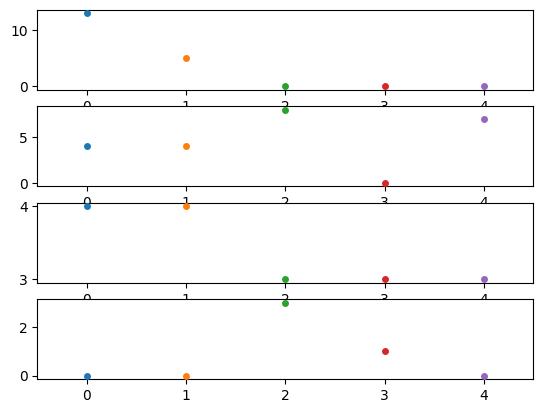

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = results.variables.WealthModel

fig, axs = plt.subplots(nrows=4)
df = pd.DataFrame([list(data["Utility (Agent 1)"])[100]])
sns.stripplot(data=df, ax=axs[0])
df = pd.DataFrame([list(data["Utility (Agent 2)"])[100]])
sns.stripplot(data=df, ax=axs[1])
df = pd.DataFrame([list(data["Utility (Agent 3)"])[100]])
sns.stripplot(data=df, ax=axs[2])
df = pd.DataFrame([list(data["Utility (Agent 4)"])[100]])
sns.stripplot(data=df, ax=axs[3])